# code

In [2]:
from skimage.feature import graycomatrix, graycoprops

In [3]:
import os
import re
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from skimage.measure import label, regionprops
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score


In [5]:
# data preprocess
metadata = pd.read_csv('data/metadata_BR00116991.csv')

if 'Metadata_gene' in metadata.columns:
    metadata.drop(columns=['Metadata_gene'], inplace=True)

# dropna
metadata.dropna(inplace=True)

def extract_file_base(filename):
    match = re.match(r'(r\d{2}c\d{2}f\d{2})', filename)
    if match:
        return match.group(1)
    else:
        return None

metadata['File_Base'] = metadata['FileName_OrigRNA'].apply(extract_file_base)

metadata = metadata.dropna(subset=['File_Base']).reset_index(drop=True)

csv_features = ['Metadata_Plate', 'Metadata_Well', 'Metadata_Site', 'Metadata_Row',
                'Metadata_target', 'Metadata_experiment_type', 'Metadata_cell_line',
                'Metadata_pert_iname', 'Metadata_pubchem_cid']

label_encoders = {}
for col in csv_features:
    if metadata[col].dtype == 'object':
        le = LabelEncoder()
        metadata[col] = le.fit_transform(metadata[col])
        label_encoders[col] = le

image_files = glob('data/Imgs/*.tiff')
image_bases = [os.path.basename(f).replace('_median_aggregated.tiff', '') for f in image_files]

mask_files = glob('data/Masks/*.tiff')
mask_bases = [os.path.basename(f).replace('mask_', '').replace('_median_aggregated.tiff', '') for f in mask_files]

common_bases = set(metadata['File_Base']).intersection(image_bases, mask_bases)

metadata_filtered = metadata[metadata['File_Base'].isin(common_bases)].reset_index(drop=True)


In [6]:
# preliminary analysis 

#Extract cell area features
cell_areas = []

for idx, row in tqdm(metadata_filtered.iterrows(), total=metadata_filtered.shape[0]):
    mask_path = f"data/Masks/mask_{row['File_Base']}_median_aggregated.tiff"
    if not os.path.exists(mask_path):
        cell_areas.append(np.nan)
        continue
    mask = imread(mask_path)
#Mark connected regions
    labeled_mask = label(mask)
#Calculate regional attributes
    props = regionprops(labeled_mask)
#Calculate Area
    areas = [prop.area for prop in props]
#Calculate the average area
    mean_area = np.mean(areas) if areas else 0
    cell_areas.append(mean_area)

metadata_filtered['Cell_Area'] = cell_areas

metadata_filtered.dropna(subset=['Cell_Area'], inplace=True)


100%|██████████████████████████████████████████████████████████████████████████████| 2277/2277 [00:43<00:00, 52.50it/s]


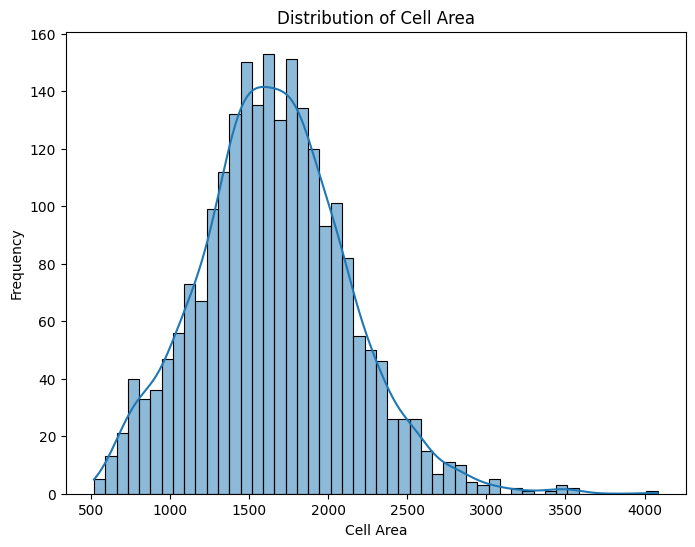

In [7]:
# Draw the distribution of Cell_Area
plt.figure(figsize=(8, 6))
sns.histplot(metadata_filtered['Cell_Area'], bins=50, kde=True)
plt.title('Distribution of Cell Area')
plt.xlabel('Cell Area')
plt.ylabel('Frequency')
plt.show()

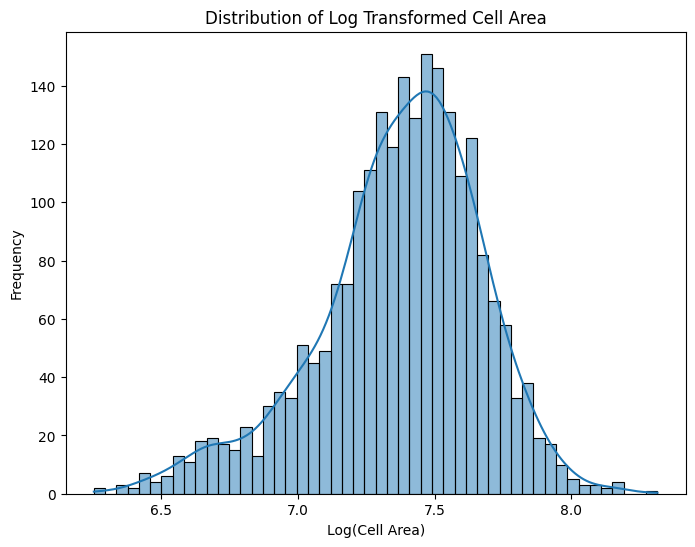

In [8]:
metadata_filtered['Log_Cell_Area'] = np.log1p(metadata_filtered['Cell_Area'])

plt.figure(figsize=(8, 6))
sns.histplot(metadata_filtered['Log_Cell_Area'], bins=50, kde=True)
plt.title('Distribution of Log Transformed Cell Area')
plt.xlabel('Log(Cell Area)')
plt.ylabel('Frequency')
plt.show()


In [12]:
# feature extraction 


#Define the function for extracting features from the original image
def extract_image_features(image):
#Calculate the gray level co-occurrence matrix
    glcm = graycomatrix(image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
#Extract texture features
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    asm = graycoprops(glcm, 'ASM')[0, 0]
#Calculate the average intensity
    mean_intensity = np.mean(image)
    return [contrast, dissimilarity, homogeneity, energy, correlation, asm, mean_intensity]

def extract_mask_features(mask):
    labeled_mask = label(mask)
    props = regionprops(labeled_mask)
    areas = [prop.area for prop in props]
    perimeters = [prop.perimeter for prop in props]
    eccentricities = [prop.eccentricity for prop in props]
    mean_area = np.mean(areas) if areas else 0
    mean_perimeter = np.mean(perimeters) if perimeters else 0
    mean_eccentricity = np.mean(eccentricities) if eccentricities else 0
    return [mean_area, mean_perimeter, mean_eccentricity]


In [13]:
#Extract features from all samples
image_features_list = []
mask_features_list = []

for idx, row in tqdm(metadata_filtered.iterrows(), total=metadata_filtered.shape[0]):
    image_path = f"data/Imgs/{row['File_Base']}_median_aggregated.tiff"
    mask_path = f"data/Masks/mask_{row['File_Base']}_median_aggregated.tiff"
    if not os.path.exists(image_path) or not os.path.exists(mask_path):
        image_features_list.append([np.nan]*7)
        mask_features_list.append([np.nan]*3)
        continue
    image = imread(image_path)
    mask = imread(mask_path)
    image_features = extract_image_features(image)
    mask_features = extract_mask_features(mask)
    image_features_list.append(image_features)
    mask_features_list.append(mask_features)

image_features_df = pd.DataFrame(image_features_list, columns=['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'ASM', 'Mean_Intensity'])
mask_features_df = pd.DataFrame(mask_features_list, columns=['Mean_Area', 'Mean_Perimeter', 'Mean_Eccentricity'])

metadata_features = pd.concat([metadata_filtered.reset_index(drop=True), image_features_df, mask_features_df], axis=1)
metadata_features.dropna(subset=['Contrast'], inplace=True)

100%|██████████████████████████████████████████████████████████████████████████████| 2277/2277 [02:45<00:00, 13.76it/s]


In [32]:
# Standardization of features

#Select numerical features
numeric_cols = ['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'ASM',
                'Mean_Intensity', 'Mean_Perimeter', 'Mean_Eccentricity'] + csv_features

scaler = StandardScaler()
scaled_features = scaler.fit_transform(metadata_features[numeric_cols])

X = pd.DataFrame(scaled_features, columns=numeric_cols)

y = metadata_features['Log_Cell_Area'].values


In [33]:
X

,Contrast,Dissimilarity,Homogeneity,Energy,Correlation,ASM,Mean_Intensity,Mean_Perimeter,Mean_Eccentricity,Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_Row,Metadata_target,Metadata_experiment_type,Metadata_cell_line,Metadata_pert_iname,Metadata_pubchem_cid
0,-0.961391,-0.663448,0.275631,0.130957,0.578109,-0.048672,-0.374157,-0.712716,0.022329,0.0,-1.725218,-1.549193,-1.563817,-1.184150,0.0,0.0,0.790543,-0.235202
1,-0.361955,1.303681,-2.404309,-2.249964,-1.222608,-1.397798,2.647205,-1.697611,-0.500840,0.0,-1.725218,-1.161895,-1.563817,-1.184150,0.0,0.0,0.790543,-0.235202
2,-0.482002,-0.236299,-0.263047,-0.708504,-0.292779,-0.749766,0.006029,-0.095706,0.695487,0.0,-1.725218,-0.774597,-1.563817,-1.184150,0.0,0.0,0.790543,-0.235202
3,-1.758314,-1.881324,1.470077,1.280381,0.496197,1.309545,-1.736085,2.131458,1.538995,0.0,-1.725218,-0.387298,-1.563817,-1.184150,0.0,0.0,0.790543,-0.235202
4,-0.864897,0.037173,-1.092285,-1.512847,0.143325,-1.191199,0.817682,-1.295812,0.283914,0.0,-1.725218,0.000000,-1.563817,-1.184150,0.0,0.0,0.790543,-0.235202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2272,1.310506,1.525129,-1.094077,-0.733722,-0.769573,-0.767029,1.281756,-0.594187,-0.590841,0.0,1.725218,0.000000,1.811113,-0.085221,0.0,0.0,0.547801,-0.641079
2273,-0.067511,-0.169937,0.348116,0.541470,0.743326,0.383569,-0.229416,0.250657,0.416011,0.0,1.725218,0.387298,1.811113,-0.085221,0.0,0.0,0.547801,-0.641079
2274,-0.514428,-0.685678,0.624525,0.774754,0.046844,0.655364,-0.862457,0.713710,-0.531140,0.0,1.725218,0.774597,1.811113,-0.085221,0.0,0.0,0.547801,-0.641079
2275,0.572753,1.072578,-1.034772,-0.566437,-1.386793,-0.648376,0.837944,-0.443823,-0.052160,0.0,1.725218,1.161895,1.811113,-0.085221,0.0,0.0,0.547801,-0.641079


In [34]:
# split
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=42)


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [26]:
# Build an improved regression model

#Define more complex regression models
class ImprovedRegressionNN(nn.Module):
    def __init__(self, input_size):
        super(ImprovedRegressionNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.layer3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.layer2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.layer3(out)
        out = self.relu3(out)
        out = self.output_layer(out)
        return out

input_size = X_train.shape[1]
model = ImprovedRegressionNN(input_size).to(device)


In [27]:
# train
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')


Epoch [10/100], Loss: 1.0273
Epoch [20/100], Loss: 0.5349
Epoch [30/100], Loss: 0.2472
Epoch [40/100], Loss: 0.0954
Epoch [50/100], Loss: 0.0326
Epoch [60/100], Loss: 0.0148
Epoch [70/100], Loss: 0.0120
Epoch [80/100], Loss: 0.0095
Epoch [90/100], Loss: 0.0073
Epoch [100/100], Loss: 0.0071


Mean Squared Error: 8753.7227
R^2 Score: 0.9628


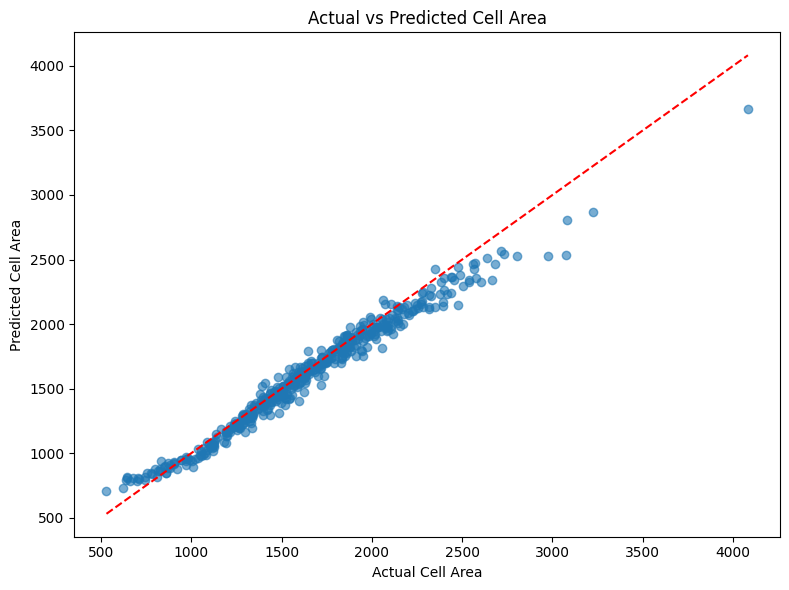

In [28]:
#Evaluation Model

#Switch to evaluation mode
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(targets.cpu().numpy())

predictions = np.array(predictions).flatten()
actuals = np.array(actuals).flatten()

predictions_exp = np.expm1(predictions)
actuals_exp = np.expm1(actuals)

mse = mean_squared_error(actuals_exp, predictions_exp)
r2 = r2_score(actuals_exp, predictions_exp)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')

plt.figure(figsize=(8, 6))
plt.scatter(actuals_exp, predictions_exp, alpha=0.6)
plt.xlabel('Actual Cell Area')
plt.ylabel('Predicted Cell Area')
plt.title('Actual vs Predicted Cell Area')
plt.plot([actuals_exp.min(), actuals_exp.max()], [actuals_exp.min(), actuals_exp.max()], 'r--')
plt.tight_layout()
plt.show()


Random Forest Mean Squared Error: 5607.6171
Random Forest R^2 Score: 0.9762


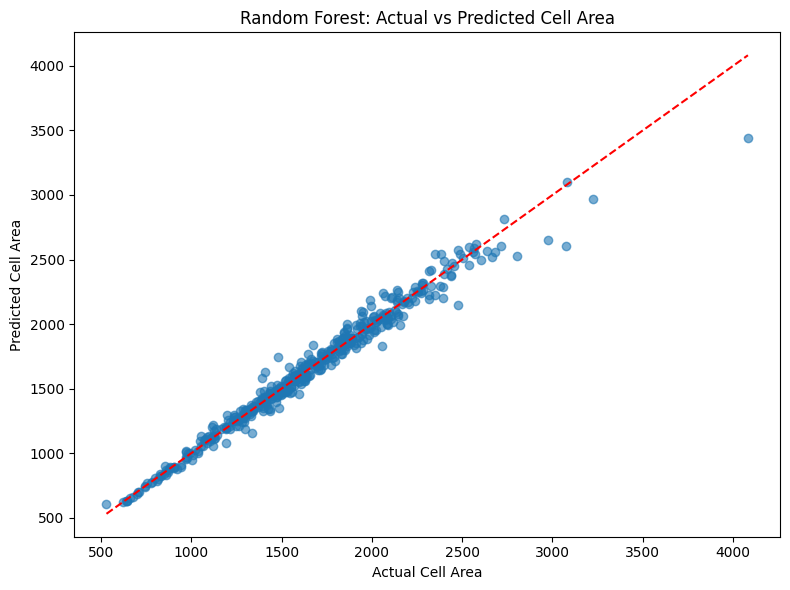

In [29]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_predictions_exp = np.expm1(rf_predictions)
actuals_exp = np.expm1(y_test)

rf_mse = mean_squared_error(actuals_exp, rf_predictions_exp)
rf_r2 = r2_score(actuals_exp, rf_predictions_exp)

print(f'Random Forest Mean Squared Error: {rf_mse:.4f}')
print(f'Random Forest R^2 Score: {rf_r2:.4f}')

plt.figure(figsize=(8, 6))
plt.scatter(actuals_exp, rf_predictions_exp, alpha=0.6)
plt.xlabel('Actual Cell Area')
plt.ylabel('Predicted Cell Area')
plt.title('Random Forest: Actual vs Predicted Cell Area')
plt.plot([actuals_exp.min(), actuals_exp.max()], [actuals_exp.min(), actuals_exp.max()], 'r--')
plt.tight_layout()
plt.show()


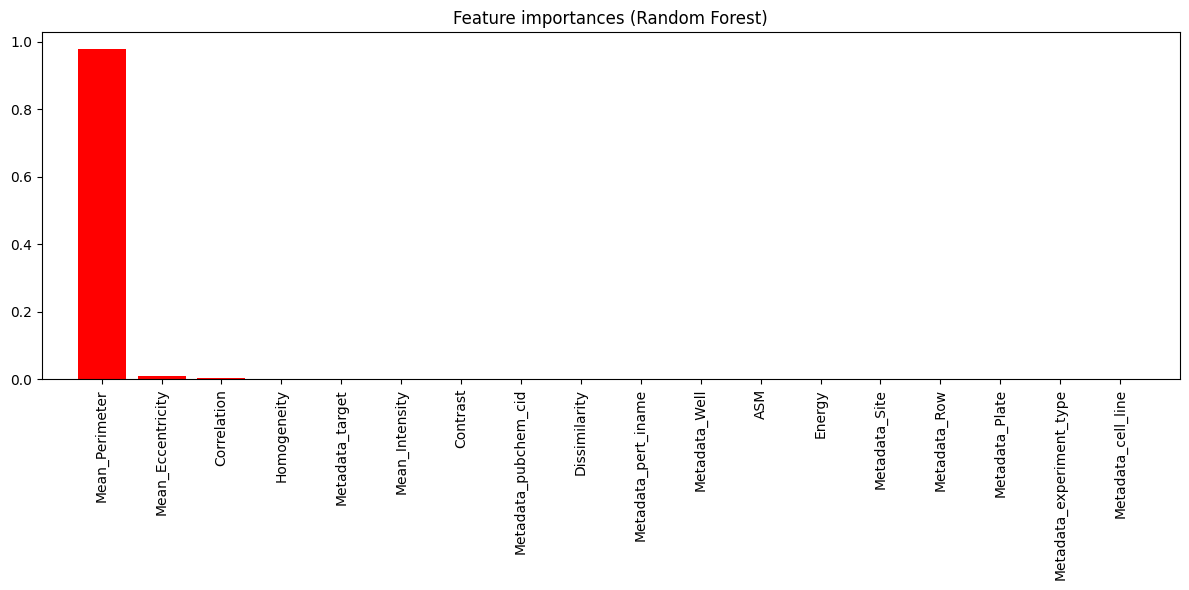

In [30]:
importances = rf_model.feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()


In [35]:
# Print feature importance values

#Print feature importance values
print("Feature importances:")
for idx in indices:
    print(f"{X.columns[idx]}: {importances[idx]:.4f}")


Feature importances:
Mean_Perimeter: 0.9785
Mean_Eccentricity: 0.0086
Correlation: 0.0031
Homogeneity: 0.0014
Metadata_target: 0.0011
Mean_Intensity: 0.0010
Contrast: 0.0010
Metadata_pubchem_cid: 0.0009
Dissimilarity: 0.0009
Metadata_pert_iname: 0.0008
Metadata_Well: 0.0007
ASM: 0.0007
Energy: 0.0006
Metadata_Site: 0.0005
Metadata_Row: 0.0003
Metadata_Plate: 0.0000
Metadata_experiment_type: 0.0000
Metadata_cell_line: 0.0000


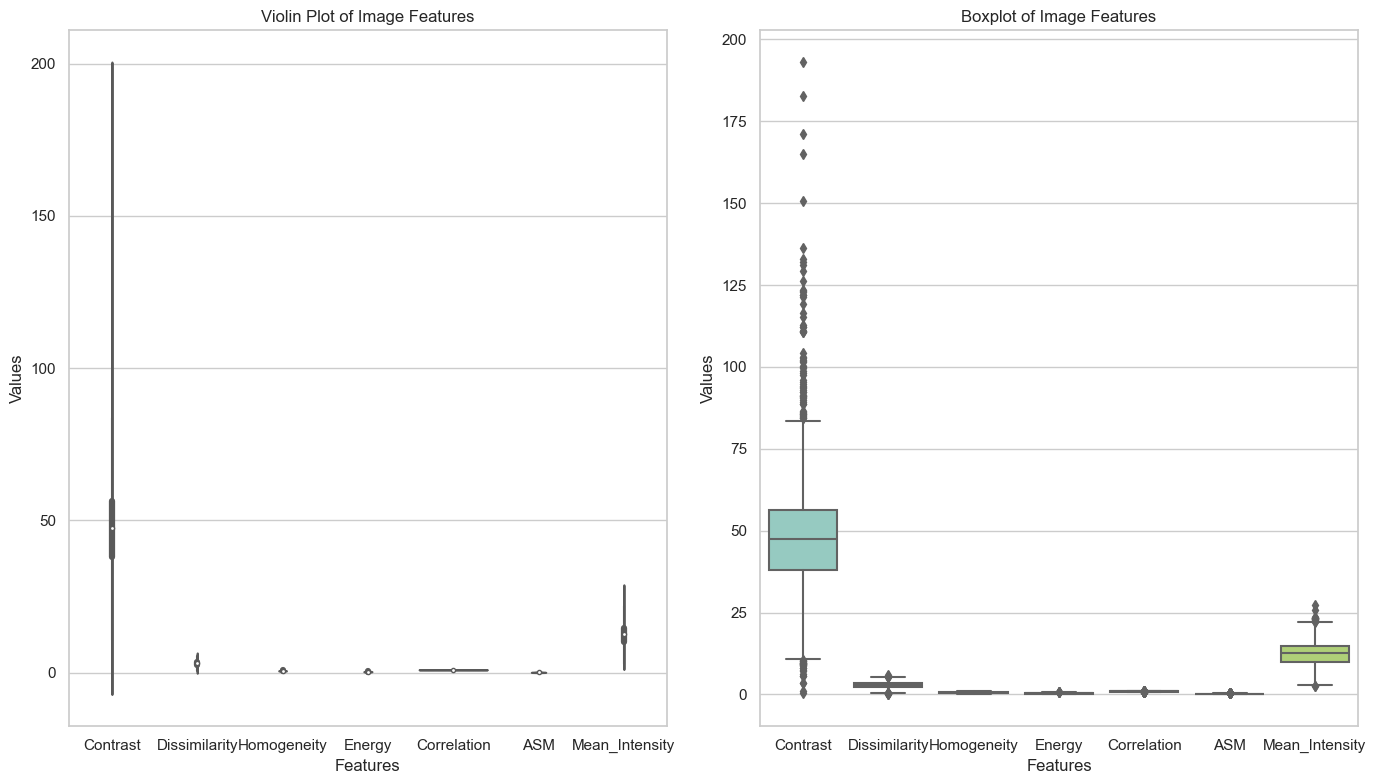

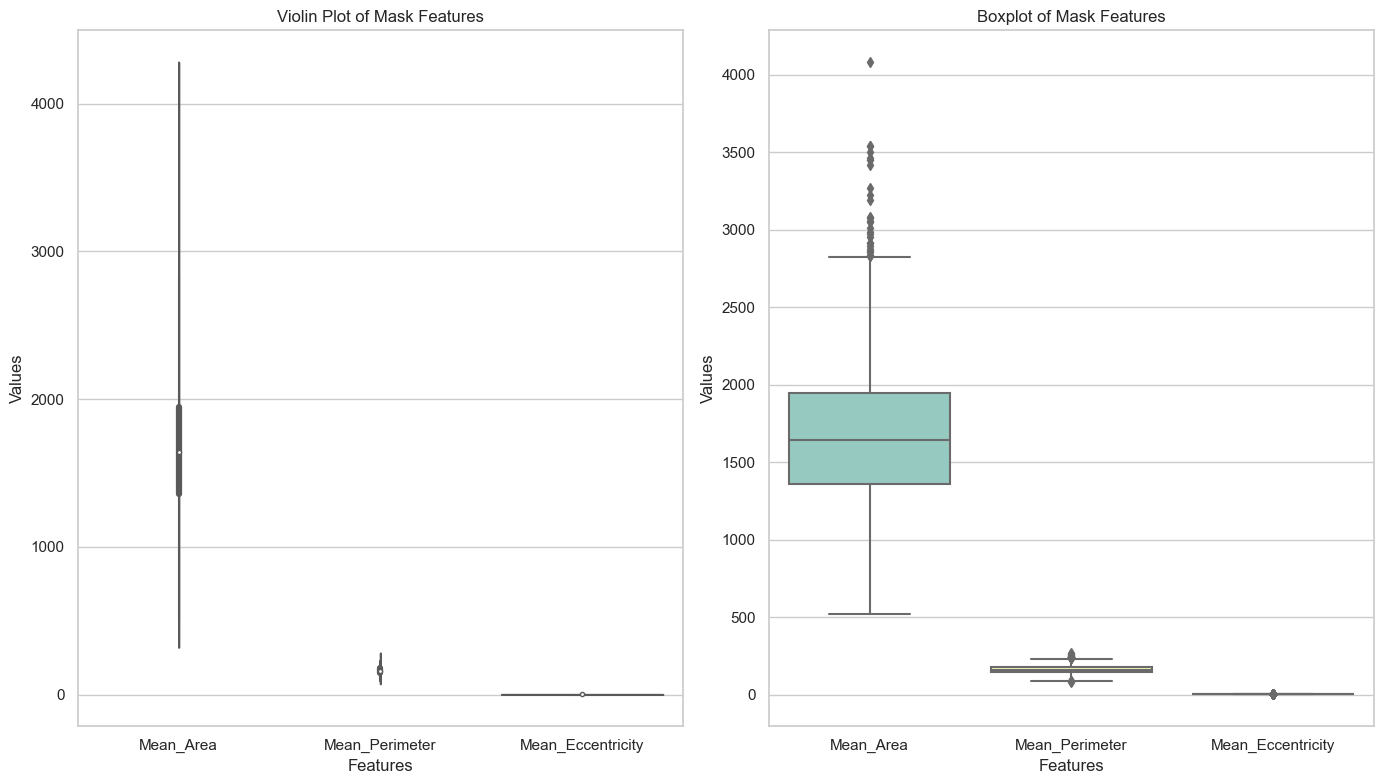

In [37]:
sns.set(style="whitegrid")

image_feature_names = ['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy',
                       'Correlation', 'ASM', 'Mean_Intensity']

mask_feature_names = ['Mean_Area', 'Mean_Perimeter', 'Mean_Eccentricity']

plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
sns.violinplot(data=metadata_features[image_feature_names], palette="Set2")
plt.title('Violin Plot of Image Features')
plt.xlabel('Features')
plt.ylabel('Values')

plt.subplot(1, 2, 2)
sns.boxplot(data=metadata_features[image_feature_names], palette="Set3")
plt.title('Boxplot of Image Features')
plt.xlabel('Features')
plt.ylabel('Values')

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
sns.violinplot(data=metadata_features[mask_feature_names], palette="Set2")
plt.title('Violin Plot of Mask Features')
plt.xlabel('Features')
plt.ylabel('Values')

plt.subplot(1, 2, 2)
sns.boxplot(data=metadata_features[mask_feature_names], palette="Set3")
plt.title('Boxplot of Mask Features')
plt.xlabel('Features')
plt.ylabel('Values')

plt.tight_layout()
plt.show()


In [38]:
# K-Means clustering analysis of image features

#Import necessary libraries
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [39]:
#Extract image features

#Ensure that we have image feature data
image_features = metadata_features[image_feature_names]

from sklearn.preprocessing import StandardScaler

scaler_image = StandardScaler()
image_features_scaled = scaler_image.fit_transform(image_features)


In [40]:
pca = PCA(n_components=2)
image_features_pca = pca.fit_transform(image_features_scaled)

#Convert the reduced dimensional data into a DataFrame
image_features_pca_df = pd.DataFrame(data=image_features_pca, columns=['PC1', 'PC2'])


In [41]:
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(image_features_scaled)

labels = kmeans.labels_
image_features_pca_df['Cluster'] = labels


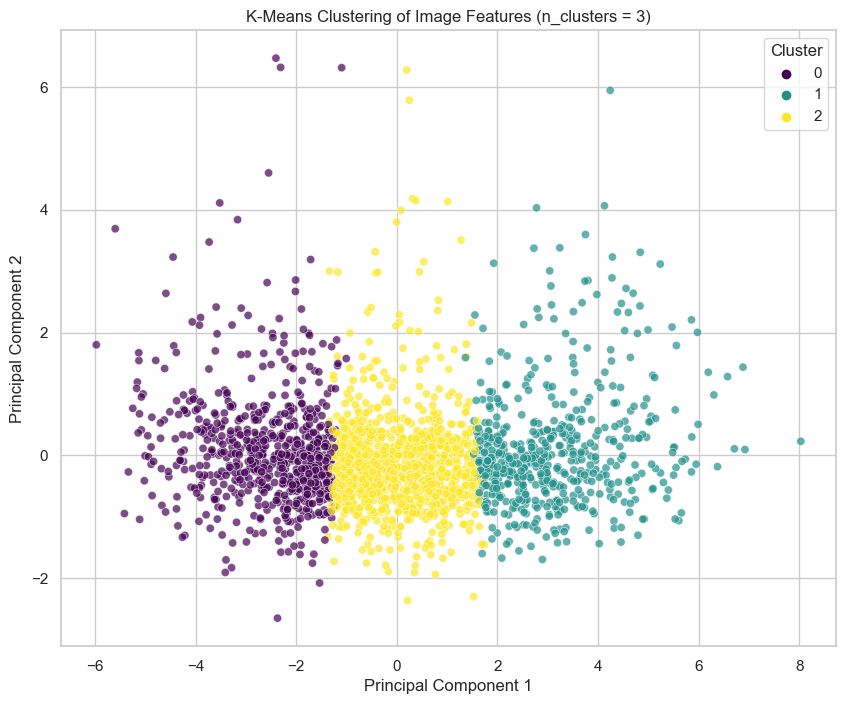

In [42]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=image_features_pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', alpha=0.7)
plt.title('K-Means Clustering of Image Features (n_clusters = {})'.format(n_clusters))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


In [43]:
#Visualize each cluster center

#Obtain clustering centers
centers = kmeans.cluster_centers_

#Restore the clustering center to the original scale (inverse standardization)
centers_inverse = scaler_image.inverse_transform(centers)

centers_df = pd.DataFrame(centers_inverse, columns=image_feature_names)
print("Cluster Centers:")
print(centers_df)


Cluster Centers:
    Contrast  Dissimilarity  Homogeneity    Energy  Correlation       ASM  \
0  60.101834       3.911144     0.467319  0.190594     0.899994  0.039787   
1  32.486073       1.751696     0.763022  0.472041     0.923446  0.226998   
2  49.069676       2.938052     0.610064  0.323044     0.916845  0.106997   

   Mean_Intensity  
0       16.360518  
1        7.723799  
2       12.244973  


Silhouette Score for Mask Features: 0.36424349448461973


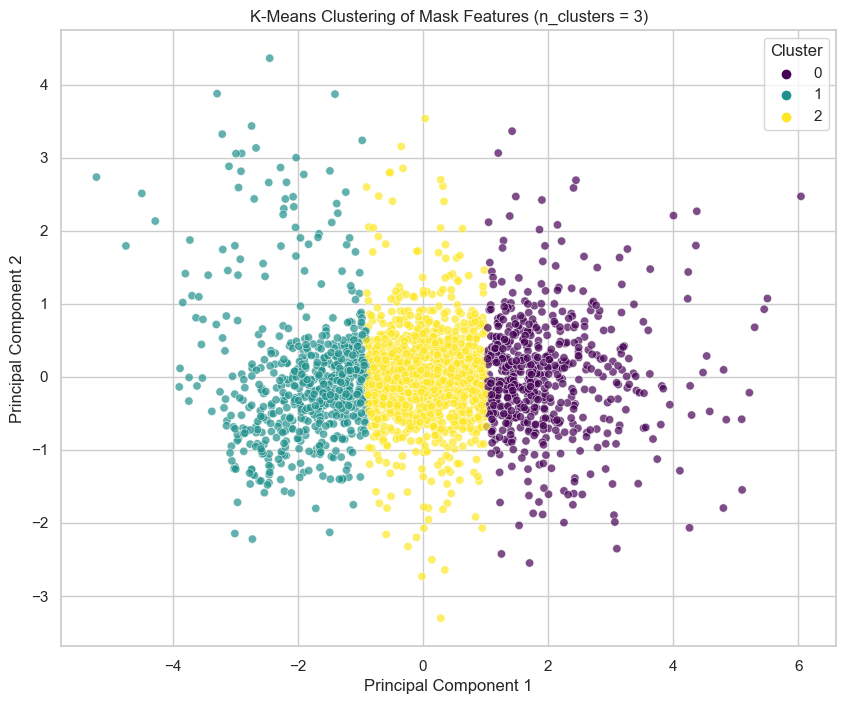

Mask Feature Cluster Centers:
     Mean_Area  Mean_Perimeter  Mean_Eccentricity
0  2237.025140      195.204763           0.712541
1  1135.373501      127.920861           0.647655
2  1663.836543      161.658703           0.678852
     Mask_Cluster  Metadata_target  Counts
0               0                0       4
1               0                1       4
2               0                2       4
3               0                3       2
4               0                4       5
..            ...              ...     ...
396             2              151       8
397             2              152      10
398             2              153       5
399             2              154       3
400             2              156       9

[401 rows x 3 columns]


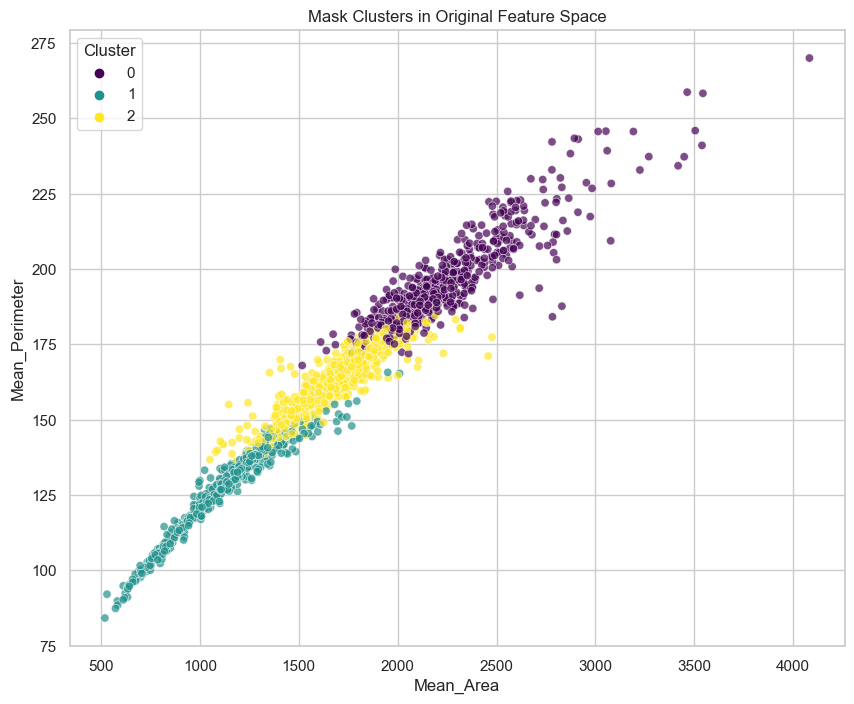

In [44]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

mask_feature_names = ['Mean_Area', 'Mean_Perimeter', 'Mean_Eccentricity']
mask_features = metadata_features[mask_feature_names]
scaler_mask = StandardScaler()
mask_features_scaled = scaler_mask.fit_transform(mask_features)

pca_mask = PCA(n_components=2)
mask_features_pca = pca_mask.fit_transform(mask_features_scaled)

mask_features_pca_df = pd.DataFrame(data=mask_features_pca, columns=['PC1', 'PC2'])

n_clusters_mask = 3

#  K-Means
kmeans_mask = KMeans(n_clusters=n_clusters_mask, random_state=42)
kmeans_mask.fit(mask_features_scaled)

labels_mask = kmeans_mask.labels_

mask_features_pca_df['Cluster'] = labels_mask

score_mask = silhouette_score(mask_features_scaled, labels_mask)
print('Silhouette Score for Mask Features:', score_mask)

plt.figure(figsize=(10, 8))
sns.scatterplot(data=mask_features_pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', alpha=0.7)
plt.title('K-Means Clustering of Mask Features (n_clusters = {})'.format(n_clusters_mask))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


centers_mask = kmeans_mask.cluster_centers_

centers_mask_inverse = scaler_mask.inverse_transform(centers_mask)
centers_mask_df = pd.DataFrame(centers_mask_inverse, columns=mask_feature_names)
print("Mask Feature Cluster Centers:")
print(centers_mask_df)
metadata_features['Mask_Cluster'] = labels_mask
cluster_target_counts_mask = metadata_features.groupby(['Mask_Cluster', 'Metadata_target']).size().reset_index(name='Counts')
print(cluster_target_counts_mask)

plt.figure(figsize=(10, 8))
sns.scatterplot(data=metadata_features, x='Mean_Area', y='Mean_Perimeter', hue='Mask_Cluster', palette='viridis', alpha=0.7)
plt.title('Mask Clusters in Original Feature Space')
plt.xlabel('Mean_Area')
plt.ylabel('Mean_Perimeter')
plt.legend(title='Cluster')
plt.show()
